<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

In [ ]:
#@title Run this to download data and prepare our environment!  { display-mode: "form" }

import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import keras

from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

###Getting the csv data loaded
!wget -O ./ferdata.csv "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv"

###Getting the Dlib Shape predictor!
!wget -O ./shape_predictor_68_face_landmarks.dat "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat"

###Getting the Xpure loaded
!wget -O ./pureX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/pureX.npy"

###Getting the Xdata loaded
!wget -O ./dataX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataX_edited.npy"

###Getting the Ydata loaded
!wget -O ./dataY.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataY.npy"

print ("Data Downloaded!")

'''
Plots the confusion Matrix and saves it
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
 
  plt.show()
  plt.close()

def plot_graphs(history, best):
  
  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

#Integer to Label Mapping
label_map = {"0":"ANGRY","1":"HAPPY","2":"SAD","3":"SURPRISE","4":"NEUTRAL"}


#Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
  
  
  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents 
  #                  the x and y co-ordinates of facial keypoints
  
  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents 
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -4
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)
    
  plt.imshow(image_copy, interpolation='nearest')
  plt.show()
  
"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
"""
  

def landmarks_edist(face_landmarks):
  
    e_dist = []
    for i, j in itertools.combinations(range(68), 2):
      e_dist.append(distance.euclidean(face_landmarks[i], face_landmarks[j]))
    
    return e_dist
  
def compare_learning(mlp, lm, cnn, vgg): # there's one model missing: MLP from pixels
  
  # summarize history for accuracy
  plt.plot(vgg.history['val_accuracy'],)
  plt.plot(cnn.history['val_accuracy'])
  plt.plot(mlp.history['val_accuracy'],)
  plt.plot(lm.history['val_accuracy'])
  plt.ylabel('validitation accuracy')
  plt.xlabel('epoch')
  plt.legend(['cnn_transfer', 'cnn_scratch', 'mlp_pixels', 'mlp_landmarks'], bbox_to_anchor=[1,1])
  plt.xticks(range(0, epochs+1, 5), range(0, epochs+1, 5))
  plt.show()


--2021-07-05 05:03:26--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.251.2.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167738172 (160M) [text/csv]
Saving to: ‘./ferdata.csv’

./ferdata.csv       100%[===================>] 159.97M   229MB/s    in 0.7s    

2021-07-05 05:03:27 (229 MB/s) - ‘./ferdata.csv’ saved [167738172/167738172]

--2021-07-05 05:03:27--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connec

In [ ]:
#@title If the previous code cell fails to download the data properly, please run this.
import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
from sklearn import metrics
from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import io

###Getting the csv data loaded
!wget -O ./ferdata.csv "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv"

###Getting the Dlib Shape predictor!
!wget -O ./shape_predictor_68_face_landmarks.dat "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat"

###Getting the Xpure loaded
!wget -O ./pureX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/pureX.npy"

###Getting the Xdata loaded
!wget -O ./dataX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataX_edited.npy"

###Getting the Ydata loaded
!wget -O ./dataY.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataY.npy"

print ("Data Downloaded!")

--2021-07-05 05:03:33--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.251.2.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167738172 (160M) [text/csv]
Saving to: ‘./ferdata.csv’

./ferdata.csv       100%[===================>] 159.97M   261MB/s    in 0.6s    

2021-07-05 05:03:34 (261 MB/s) - ‘./ferdata.csv’ saved [167738172/167738172]

--2021-07-05 05:03:34--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connec

In this notebook we'll be:
1.   Understanding and Building Neural Networks
2.   Applying Neural Networks to Predict Emotions
3.   Implementing CNNs for Emotion Detection
4.   Implementing Transfer Learning



#Understanding and building Neural Networks

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Basically, neural network algorithm helps computers think and learn like humans.

The whole idea of artificial neural network is based on the concept of the structure and functions of a human brain. A human brain consists of neurons that process and transmit information between themselves.

### Why try neural networks?

Our Baseline model performed at ~50 %

Human accuracy for fer2013 is around 65 %, suggesting that we could do better!

What we require now is a model that can capture more complicated patterns. One class of models that is able to do this and has been very effective for doing this for images are neural networks. 


### What are neural networks?


## Instructor-Led Discussion: Building networks

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`. Let's learn how to build and use these networks!

Tensorflow calls the various machine learning algorithms that it uses 'models'.  These 'models' are 'learning machines.''

1. We **teach** models by **training** them on **data**. 
2. We **use** models to **predict** things. 

Here is example code for building a Tensorflow model with Keras:

The things you'll want to pay most attention to as we go over how to build networks are: 
1. The number of neurons
2. The activation of the neurons
3. The losses and metrics

Everything else will work with the default settings!

Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network. 

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary. 

```
model.compile(loss='mean_squared_error',
               optimizer = 'adam',
               metrics = ['mean_squared_error'])
  ```
  
  Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (x), the true predictions from that data (y), and then train our model with `fit`. 

```
model.fit(x, y)
```

To use the model, you can use it to predict something with:
```
y = model.predict_classes(x)
```



### For reference, this is a lot like the kind of models we've been training with scikit learn.

The big difference is that defining the model is more involved. We can look at an example from KNN: 

```
# define the model instance 
knn = KNeighborsClassifier()

# train model with X_train
knn.fit(X_train, y_train) 

# predict testing data
y_predict = knn.predict(X_test)

```

##Exercise: Coding a 2 hidden layer MLP

Just as we went over last week, neural networks look something like this: 

![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)

Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. Let's get a bit more concrete with this...

### How can we build this network above? Fill in the ___ 's below 

In [ ]:
# First, we initialize our model
tmp_model = Sequential()
# then we add a "Dense" (i.e. fully connected) layer
tmp_model.add(Dense(7, input_shape=(5,), activation = 'relu')) # for the first layer we specify the input dimensions 
# then we have to add another layer 
tmp_model.add(Dense(7, activation = 'relu'))
# we end by defining the output layer, which has the number of dimensions of the predictions we're making
tmp_model.add(Dense(4, activation = 'linear'))
# we finalize the model by "compiling" it and defining some other hyperparameters 
tmp_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

## Exercise: Building our custom neural network

###Keypoints

We will build a simple 3-layer network for our first model!


For our model, we have as our layers: 
* Input Layer:  However many inputs there are!
* Layer 1 (Hidden): 1024 neurons that are activated by `'relu'` and weights are intialized using `kernel_initializer='glorot_normal'`. Specify the input shape as `(2278,)`.
* Layer 2 (Hidden): 512 neurons that are activated by `'relu'` and weights are intialized using `kernel_initializer='glorot_normal'`
* Layer 3 (Output): 5 neuron that should have an appropriate activation. 
* We will compile with the `optimizers.SGD(lr=0.001)` optimizer

As a hint for the output activation and the compilation loss, we know that:
* Multi-class classification problems require an output activation of `'softmax'` and a loss of `'categorical_crossentropy'`




###Build your Model (call it `perceptron`)

In [ ]:
#YOUR CODE HERE

perceptron = Sequential()

perceptron.add(Dense(1024, input_shape = (2278,), activation = 'relu', kernel_initializer = 'glorot_normal'))
perceptron.add(Dense(512, activation = 'relu', kernel_initializer = 'glorot_normal'))
perceptron.add(Dense(5, activation = 'softmax'))

perceptron.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001), metrics=['accuracy'])

#END CODE

In [ ]:
#@title Run this to test if your model is right! { display-mode: "form" }
perceptron_answer = Sequential()
perceptron_answer.add(Dense(units = 1024, input_shape = (2278,),kernel_initializer='glorot_normal',activation = 'relu'))
perceptron_answer.add(Dense(units = 512,kernel_initializer='glorot_normal' , activation = 'relu'))
perceptron_answer.add(Dense(units = 5, activation = 'softmax'))
    
perceptron_answer.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=0.001),
    metrics=['accuracy'])

if model_to_string(perceptron) == model_to_string(perceptron_answer):
  print('Good job, you specified it correctly!')
else: 
  print('Please check your code again!')

Good job, you specified it correctly!


###Keras Neural Network Model Hyperparameters

Neural Network performance depends a lot on *how much* they train. As we'll see, they usually get better with more training BUT actually can get worse with too much training. With too much training, our model can get overconfident in its abilities with the training manual (overfitting), and so doesn't actually think (generalize) when it is tested. 

The  `fit()` function pertain to how the neural networks train. Don't worry too much about the extra options, what really matters for us is that the right data is specified.


What are all these options?
* `epochs`: how many times the model trains on the entire data set
* `batch_size`: number of samples processed at a time
* `shuffle`: mixes the training dataset so the model pays better attention to the data and learns better while training
* `validation_data`: we request that our model tests itself on the `test_data` after every epoch. **It is essential to use validation data to test for overfitting!**
* `callbacks`: With a custom command, we tell our model to save the best version of itself to a model file called `best_dnn_model.h5`. 


#Applying Neural Networks (MLPs) to predicting emotions

### Loading and formatting data for all models in notebook 

First, let's try to build a 4-Layer Neural Network  for our training data to achieve accuracy closer to the human accuracy on the dataset (around 65%)

We want to identify the key things that we need to design our network. 

In your group, discuss: 

* What are our inputs?
* What is/are our outputs?

How could this look in a neural network diagram?

**Show your instructor your diagram once you're done!!**

##Activity: Train Neural Network on Emotion Dataset

###Set some hyper parameters for all models

In [ ]:
# the number of times we pass all the training data through the model 
epochs = 20
# the number of examples we pass to the model at each time
batch_size = 64
# the proportion of testing data we set aside (e.g. 10%)
test_ratio = .1
# the number of emotion categories we have to predict
n_labels = 5 

###Load the original (unprocessed) data saved on Day 2!

In [ ]:
# load data 
dataX_pixels = np.load('pureX.npy')
dataY_pixels = np.load('dataY.npy')

### Convert labels to one-hot encoded labels

One hot encoding is a representation of categorical variables as binary vectors

In [ ]:
# convert labels to one hot encoding
y_onehot = to_categorical(dataY_pixels, len(set(dataY_pixels)))

# what does this data type look like? 

y_onehot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
#@title Is it clear how these are two equivalent ways to represent the target?


###Split and Standardize your Data



In [ ]:
# split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX_pixels, y_onehot, test_size=test_ratio, random_state=42)

#### Standardize the data ##########
pixel_scaler = StandardScaler()
pixel_scaler.fit(X_train)
X_train = pixel_scaler.transform(X_train)
X_test = pixel_scaler.transform(X_test)

## Exercise: Build a simple MLP for emotion detection (call it `mlp_model`)


In [ ]:
#YOUR CODE HERE

mlp_model = Sequential()

mlp_model.add(Dense(1024, input_shape = (X_train.shape[1],), activation = 'relu', kernel_initializer = 'glorot_normal'))
mlp_model.add(Dropout(rate = 0.5))
mlp_model.add(Dense(512, activation = 'relu', kernel_initializer = 'glorot_normal'))
mlp_model.add(Dense(5, activation = 'softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001), metrics=['accuracy'])




#END CODE

In [ ]:
# Compiling the model with SGD optimixer and categorical crossentropy loss
mlp_model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=['accuracy'])
              
#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_mlp_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True,  mode='auto')  

#training the model
mlp_history = mlp_model.fit(X_train, y_train, batch_size=batch_size, epochs=30, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test, y_test), shuffle=True)

Epoch 1/30
282/282 [==============================] - 15s 5ms/step - loss: 1.8875 - accuracy: 0.2358 - val_loss: 1.5581 - val_accuracy: 0.3095

Epoch 00001: val_accuracy improved from -inf to 0.30950, saving model to best_mlp_model.h5
Epoch 2/30
282/282 [==============================] - 1s 4ms/step - loss: 1.6920 - accuracy: 0.2885 - val_loss: 1.5046 - val_accuracy: 0.3515

Epoch 00002: val_accuracy improved from 0.30950 to 0.35150, saving model to best_mlp_model.h5
Epoch 3/30
282/282 [==============================] - 1s 4ms/step - loss: 1.6216 - accuracy: 0.3105 - val_loss: 1.4775 - val_accuracy: 0.3585

Epoch 00003: val_accuracy improved from 0.35150 to 0.35850, saving model to best_mlp_model.h5
Epoch 4/30
282/282 [==============================] - 1s 3ms/step - loss: 1.5904 - accuracy: 0.3354 - val_loss: 1.4558 - val_accuracy: 0.3790

Epoch 00004: val_accuracy improved from 0.35850 to 0.37900, saving model to best_mlp_model.h5
Epoch 5/30
282/282 [==============================] - 

##Neural Network Model Evaluation on pixel inputs

###Evaluate best model

In [ ]:
mlp_performance = mlp_model.evaluate(X_test, y_test, batch_size=64)

32/32 [==============================] - 0s 2ms/step - loss: 1.3322 - accuracy: 0.4565


###Visualize accuracy and loss over training + display best model's performance

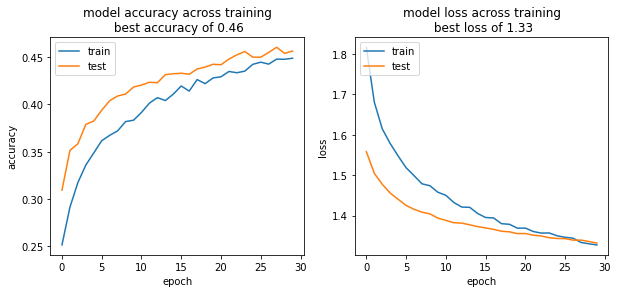

In [ ]:
plot_graphs(mlp_history, mlp_performance); 

###Plot the Confusion Matrix

Plotting the Confusion Matrix


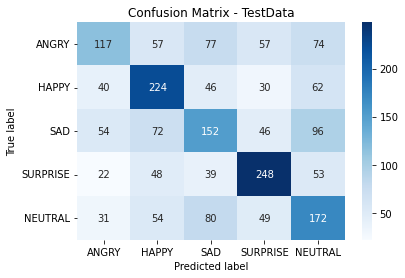

In [ ]:
y_pred_mlp = mlp_model.predict_classes(X_test)
y_true = np.argmax(y_test,axis=1)
plot_confusion_matrix(y_true, y_pred_mlp)

##Neural Network Model Evaluation on distance inputs

We saw yesterday that building a model on the distances between facial landmarks did better than on raw pixel inputs, is this true for these models as well? 

In [ ]:
#Load the data (Distances between facial Landmarks)
dataX_lm = np.load('./dataX.npy')
#dataY_lm = np.load('./dataY.npy')

# convert labels to one hot encoding
#y_onehot = to_categorical(dataY_lm, len(set(dataY_lm)))

# split Data into Train, Test (90-10)
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(dataX_lm, y_onehot, test_size=0.1, random_state=42)

#### Standardize the data ##########
lm_scaler = StandardScaler()
lm_scaler.fit(X_train_lm)
X_train_lm = lm_scaler.transform(X_train_lm)
X_test_lm = lm_scaler.transform(X_test_lm)

In [ ]:
#YOUR CODE HERE
#YOUR CODE HERE
#YOUR CODE HERE
#YOUR CODE HERE
############### CALL YOUR MODEL 'lm_model' 

lm_model = Sequential()

lm_model.add(Dense(1024, input_shape = (2278,), activation = 'relu', kernel_initializer = 'glorot_normal'))
lm_model.add(Dropout(rate=0.5))
lm_model.add(Dense(512, activation = 'relu', kernel_initializer = 'glorot_normal'))
lm_model.add(Dense(5, activation = 'softmax'))

lm_model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=['accuracy'])
#YOUR CODE HERE
#YOUR CODE HERE
#YOUR CODE HERE
#YOUR CODE HERE

In [ ]:
# Compliling the model with SGD optimixer and categorical crossentropy loss
lm_model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=['accuracy'])

#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_lm_model.h5', verbose=1, monitor='val_loss',save_best_only=True,  mode='auto')  
#training the model
lm_history = lm_model.fit(X_train_lm, y_train_lm, batch_size=batch_size, epochs=50, 
                          verbose=1, callbacks=[checkpoint], validation_data=(X_test_lm, y_test_lm), shuffle=True)

Epoch 1/50
282/282 [==============================] - 2s 4ms/step - loss: 1.7056 - accuracy: 0.3045 - val_loss: 1.3179 - val_accuracy: 0.4350

Epoch 00001: val_loss improved from inf to 1.31793, saving model to best_lm_model.h5
Epoch 2/50
282/282 [==============================] - 1s 4ms/step - loss: 1.4741 - accuracy: 0.3995 - val_loss: 1.2737 - val_accuracy: 0.4580

Epoch 00002: val_loss improved from 1.31793 to 1.27370, saving model to best_lm_model.h5
Epoch 3/50
282/282 [==============================] - 1s 4ms/step - loss: 1.3915 - accuracy: 0.4344 - val_loss: 1.2566 - val_accuracy: 0.4750

Epoch 00003: val_loss improved from 1.27370 to 1.25660, saving model to best_lm_model.h5
Epoch 4/50
282/282 [==============================] - 1s 3ms/step - loss: 1.3659 - accuracy: 0.4410 - val_loss: 1.2359 - val_accuracy: 0.4805

Epoch 00004: val_loss improved from 1.25660 to 1.23585, saving model to best_lm_model.h5
Epoch 5/50
282/282 [==============================] - 1s 3ms/step - loss: 1.

### Evaluate model

In [ ]:
lm_performance = lm_model.evaluate(X_test_lm, y_test_lm, batch_size=64)
lm_performance

32/32 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.5390


[1.1357940435409546, 0.5389999747276306]

###Visualize accuracy and loss over training + display best model's performance

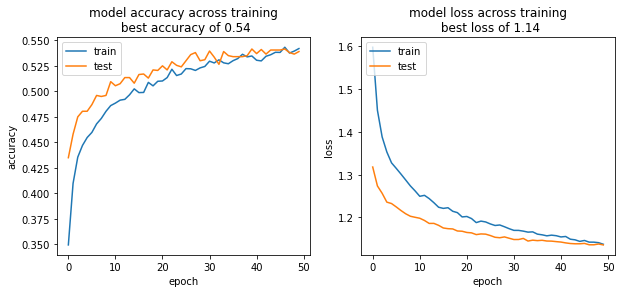

In [ ]:
# YOUR CODE HERE
# YOUR CODE HERE
#Saves the Best Model Based on Val Loss
plot_graphs(lm_history, lm_performance); 

## Instructor-Led Discussion

How can we explain the difference between these two models?

#Convolutional Neural Networks for Emotion Detection!

###Model Hyperparameters

In [ ]:
# we'll use the same epochs and batch size as above
width, height = 48, 48

###Reshape the inputs

In [ ]:
# pixels were vectors
print(X_train.shape) 

(18000, 2304)


In [ ]:
X_train_cnn = X_train.reshape(len(X_train),height,width)
X_test_cnn = X_test.reshape(len(X_test),height,width)

# we've converted them to images
print(X_train_cnn.shape) 
# now we add one more dimension for model compatability
print(X_test_cnn.shape) 


(18000, 48, 48)
(2000, 48, 48)


In [ ]:
# now we add one more dimension for model compatability
X_train_cnn = np.expand_dims(X_train_cnn,3)
X_test_cnn = np.expand_dims(X_test_cnn,3)

print(X_train_cnn.shape)

(18000, 48, 48, 1)


In [ ]:
# Change the hyperparameters in the model below 

# initialize model
cnn_model = Sequential()
# this conv layer has 64 filters! the input shape needs to be the same dimensions of the image
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

# flatten all the outputs between convolutional and dense layers
cnn_model.add(Flatten())
# add a "dense layer" (i.e. the fully connected layers in MLPs) with dropout
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(256, activation = 'relu'))
cnn_model.add(Dense(128, activation = 'relu'))
cnn_model.add(Dropout(rate=0.5))
# output layer
cnn_model.add(Dense(n_labels, activation='softmax'))

In [ ]:
#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_cnn_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# compliling the model with adam optimixer and categorical crossentropy loss
cnn_model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

# training the model
cnn_history = cnn_model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=35, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test_cnn, y_test), shuffle=True)

Epoch 1/35
282/282 [==============================] - 48s 48ms/step - loss: 1.7723 - accuracy: 0.2411 - val_loss: 1.7167 - val_accuracy: 0.2180

Epoch 00001: val_loss improved from inf to 1.71672, saving model to best_cnn_model.h5
Epoch 2/35
282/282 [==============================] - 12s 43ms/step - loss: 1.4621 - accuracy: 0.3364 - val_loss: 1.3432 - val_accuracy: 0.4140

Epoch 00002: val_loss improved from 1.71672 to 1.34316, saving model to best_cnn_model.h5
Epoch 3/35
282/282 [==============================] - 12s 43ms/step - loss: 1.3744 - accuracy: 0.4021 - val_loss: 1.3261 - val_accuracy: 0.4390

Epoch 00003: val_loss improved from 1.34316 to 1.32613, saving model to best_cnn_model.h5
Epoch 4/35
282/282 [==============================] - 12s 44ms/step - loss: 1.2532 - accuracy: 0.4752 - val_loss: 1.1100 - val_accuracy: 0.5445

Epoch 00004: val_loss improved from 1.32613 to 1.10997, saving model to best_cnn_model.h5
Epoch 5/35
282/282 [==============================] - 13s 44ms/s

###Evaluate the model

In [ ]:
cnn_performance = cnn_model.evaluate(X_test_cnn, y_test, batch_size=64)
cnn_performance

32/32 [==============================] - 0s 14ms/step - loss: 1.1279 - accuracy: 0.6945


[1.1278973817825317, 0.6945000290870667]

###Plot Accuracy and Loss

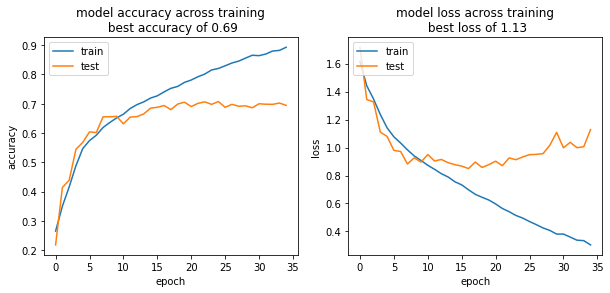

In [ ]:
plot_graphs(cnn_history, cnn_performance); 

## Instructor-Led Discussion

How does this model compare with the others? Did this perform as well as we wanted it to? What might be some of the reasons why?

#Transfer Learning

In [ ]:
#@title Run this to build your transfer learning model { display-mode: "form" }

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.applications.vgg16 import VGG16

# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

# we add the first 12 layers of vgg to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(5, activation = 'sigmoid'))

# finally, we build the vgg model and turn it on so we can use it!
vgg_model.compile(loss = 'categorical_crossentropy', 
          optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
          metrics=['accuracy'])

X_TRAIN = np.array([np.transpose(np.array([X_train_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_train))])
X_TEST = np.array([np.transpose(np.array([X_test_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_test))])

#training the model
vgg_history = vgg_model.fit(X_TRAIN, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpoint],
          validation_data=(X_TEST, y_test),
          shuffle=True)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/20
282/282 [==============================] - 22s 67ms/step - loss: 1.6100 - accuracy: 0.2565 - val_loss: 1.3201 - val_accuracy: 0.4385

Epoch 00001: val_loss did not improve from 0.84971
Epoch 2/20
282/282 [==============================] - 18s 63ms/step - loss: 1.3062 - accuracy: 0.4333 - val_loss: 1.1445 - val_accuracy: 0.5240

Epoch 00002: val_loss did not improve from 0.84971
Epoch 3/20
282/282 [==============================] - 18s 63ms/step - loss: 1.1536 - accuracy: 0.5264 - val_loss: 1.0388 - val_accuracy: 0.5830

Epoch 00003: val_loss did not improve from 0.84971
Epoch 4/20
282/282 [==============================] - 18s 62ms/step - loss: 1.0497 - accuracy: 0.5809 - val_loss: 1.0141 - val_accuracy: 0.5970

Epoch 00004: val_loss did not improve from 0.84971
Epoch 5/20
282/282 [==============================] - 18s 62ms/step - loss: 1.0010 - accuracy: 0.6017 - val_loss: 0.9748 - val_accuracy: 0.6125

Epoch 

###Evaluate model

###Visualize accuracy and loss over training + display best model's performance

32/32 [==============================] - 1s 18ms/step - loss: 0.9177 - accuracy: 0.6840


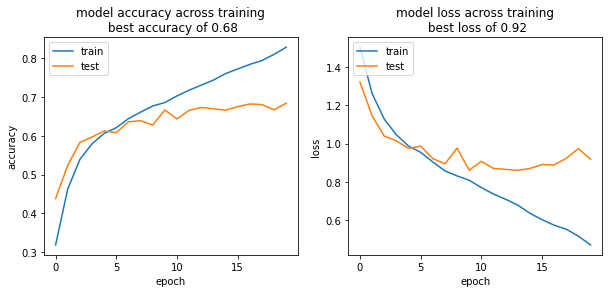

In [ ]:
vgg_performance = vgg_model.evaluate(X_TEST, y_test, batch_size=64)
plot_graphs(vgg_history, vgg_performance); 


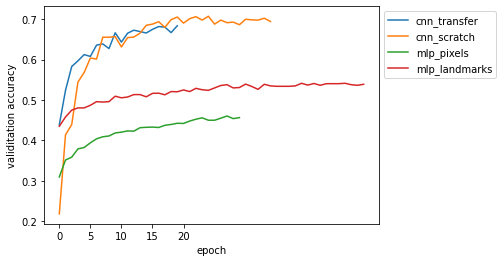

In [ ]:
compare_learning(mlp_history, lm_history, cnn_history, vgg_history)

###How can we explain this pattern of performance across all these models?

# Finished :D